# Monitoramento e Fairness

In [29]:
import pandas as pd
import joblib
from sklearn.metrics import classification_report, confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns
import os

## Carregar modelo e vetor já treinados

In [30]:
modelo_path = "../model.joblib"
vetor_path = "../vectorizer.joblib"
dados_path = "../data/tweets_limpo.csv"

if not (os.path.exists(modelo_path) and os.path.exists(vetor_path)):
    raise FileExistsError("Treine e salve o modelo antes de executar!")

model = joblib.load(modelo_path)
vectorizer = joblib.load(vetor_path)
df = pd.read_csv(dados_path)
display(df.head())

,text,label,text_length
0,Adorei o produto de investimentos no mercado d...,positivo,56
1,O serviço de instalação internet doi péssimo. ...,negativo,59
2,Entrega rápida com atendimento excelente,positivo,40
3,Não voltarei a comprar,negativo,22
4,"Adorei o produto, superou minhas expectativas!",positivo,46


## Monitoramento

In [31]:
novos_textos = [
    "Muito ruim, não gostei do atendimento.",
    "A entrega foi sensacional!",
    "Não funcionou, me decepcionei",
    "Recomendo para todos, nota 10!",
    "Recomendo para todos, top!"
]

novos_df = pd.DataFrame({'text': novos_textos})
display(novos_df)

,text
0,"Muito ruim, não gostei do atendimento."
1,A entrega foi sensacional!
2,"Não funcionou, me decepcionei"
3,"Recomendo para todos, nota 10!"
4,"Recomendo para todos, top!"


In [32]:
novos_vetores = vectorizer.transform(novos_df["text"])
novos_preds = model.predict(novos_vetores)
novos_df['sentimento_predito'] = novos_preds
display(novos_df)

,text,sentimento_predito
0,"Muito ruim, não gostei do atendimento.",negativo
1,A entrega foi sensacional!,positivo
2,"Não funcionou, me decepcionei",negativo
3,"Recomendo para todos, nota 10!",positivo
4,"Recomendo para todos, top!",positivo


In [33]:
class_dict = novos_df["sentimento_predito"].value_counts(normalize=True)
print("Distribuição dos sentimentos preditos no novos dados:")
print(class_dict)

Distribuição dos sentimentos preditos no novos dados:
sentimento_predito
positivo    0.6
negativo    0.4
Name: proportion, dtype: float64


## Fairness - Vieses

In [34]:
df["text_len"]= df["text"].apply(len)
df["len_category"]= pd.cut(df["text_len"], bins=[0,50,150,1000], labels=["curto", "medio", "longo"])

In [35]:
df

,text,label,text_length,text_len,len_category
0,Adorei o produto de investimentos no mercado d...,positivo,56,56,medio
1,O serviço de instalação internet doi péssimo. ...,negativo,59,59,medio
2,Entrega rápida com atendimento excelente,positivo,40,40,curto
3,Não voltarei a comprar,negativo,22,22,curto
4,"Adorei o produto, superou minhas expectativas!",positivo,46,46,curto
5,"O serviço foi péssimo, não recomendo.",negativo,37,37,curto
6,Entrega rápida e atendimento excelente.,positivo,39,39,curto
7,"Produto veio com defeito, estou decepcionado.",negativo,45,45,curto
8,Gostei muito da qualidade.,positivo,26,26,curto
9,Não funcionou como esperado.,negativo,28,28,curto


## Predições conjunto de validação

In [36]:
vetores = vectorizer.transform(df["text"])
df["pred"] = model.predict(vetores)
display(df["pred"])

0     positivo
1     negativo
2     positivo
3     negativo
4     positivo
5     negativo
6     positivo
7     negativo
8     positivo
9     negativo
10    positivo
11    negativo
12    positivo
13    positivo
14    positivo
15    negativo
Name: pred, dtype: object

## Avaliação de acurácia

In [37]:
for cat in df["len_category"].unique():
    subset = df[df["len_category"] == cat]
    if not subset.empty:
        acuracia = (subset["label"] == subset["pred"]).mean()
        print(f"Acurária para os textos {cat}: {acuracia:.2f} (N={len(subset)})")

Acurária para os textos medio: 1.00 (N=2)
Acurária para os textos curto: 1.00 (N=14)


## Desafio fairness

Matriz de confusão para textos medio: 
[[1 0]
 [0 1]]


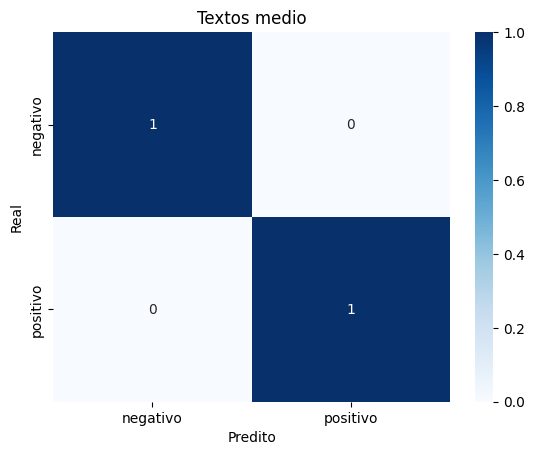

Matriz de confusão para textos curto: 
[[6 0]
 [0 8]]


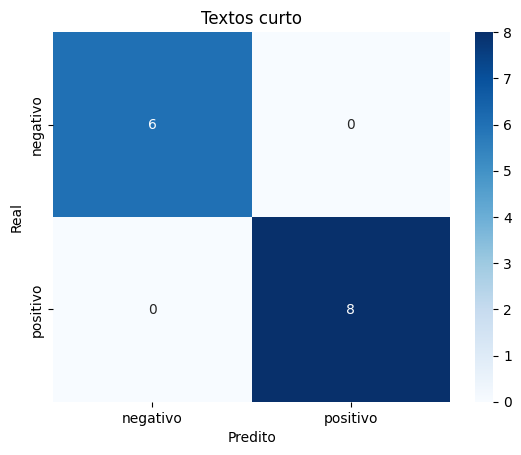

In [38]:
for cat in df["len_category"].unique():
    subset = df[df["len_category"] == cat]
    if not subset.empty:
        print(f"Matriz de confusão para textos {cat}: ")
        print(confusion_matrix(subset["label"], subset["pred"]))
        sns.heatmap(
            confusion_matrix(
                subset["label"],
                subset["pred"]
            ),
            annot=True, fmt="d",cmap="Blues",
            xticklabels=["negativo", "positivo"],
            yticklabels=["negativo", "positivo"],
        )
        plt.title(f"Textos {cat}")
        plt.xlabel("Predito")
        plt.ylabel("Real")
        plt.show()